In [1]:
import ROOT as r
import math
import array
import os
import sys
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________

import CONFIG
import DBPARSE
from UTILITIES import *
from SIMFITS2D import DistributionFits2D
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend


Welcome to JupyROOT 6.26/06


In [2]:
csv_file='../outfiles/file.csv'

df = pd.read_csv(csv_file) 

In [3]:
%%time
#-chatgpt is beautiful------------#
def find_closest_row(df, target_q2, target_x):
       
    closest_q2 = df['Q2'].iloc[(df['Q2'] - target_q2).abs().argmin()]    
    filtered_df = df[df['Q2'] == closest_q2]    
    closest_x = filtered_df['X'].iloc[(filtered_df['X'] - target_x).abs().argmin()]    
    closest_row = filtered_df[(filtered_df['X'] == closest_x)].iloc[0]    
    return closest_row

target_q2 = 0.266
target_x = 0.1626

row = find_closest_row(df, target_q2, target_x)
print(row)
#-chatgpt is beautiful------------#


Q2              0.270000
X               0.163000
F2_Inelastic    0.741732
FL_Inelastic    0.255288
F1_Inelastic    2.280583
G1_Inelastic   -0.024442
G2_Inelastic    0.197914
F2_QE           0.002317
FL_QE           0.124165
F1_QE          -0.371302
G1_QE          -0.001082
G2_QE          -0.000218
F2_IpQE         0.744050
FL_IpQE         0.379452
F1_IpQE         1.909281
G1_IpQE        -0.025524
G2_IpQE         0.197696
Name: 351162, dtype: float64
CPU times: user 8.44 ms, sys: 469 µs, total: 8.91 ms
Wall time: 7.93 ms


In [4]:
#Inelastic Plus Quasi
#F1=row[-3]
#F2=row[-5]


In [5]:
#NeutronMass
M=.939
electronEnergyInterval=11-.5
hbarc=3.89e-28

# Unpolarized Cross Section

$$
\displaystyle \frac{d^2 \sigma}{d\Omega dE'} = \frac{d^2 \sigma_{Mott}}{d\Omega} \cdot \left( \frac{F_2(x, Q^2)}{\nu} + \frac{2}{M} \tan^2\frac{\theta}{2} F_1(x, Q^2) \right)
$$

$$
\displaystyle \frac{d^2\sigma_{Mott}}{d\Omega} = \left(\frac{\alpha \cos\left(\frac{\theta}{2}\right)}{2E \sin^2\left(\frac{\theta}{2}\right)}\right)^2
$$

In [6]:
theta=3.14

In [7]:
np.cos(theta / 2)

0.0007963267107332633

In [8]:
#MOTT CROSS SECTION

def Function_MOTT(E, theta):
    alpha = 1 / 137  # Fine-structure constant
    cos_theta_half = np.cos(theta / 2)
    sin_theta_half = np.sin(theta / 2)
    sigma_mott = (alpha * cos_theta_half / (2 * E * sin_theta_half**2))**2
    
    return sigma_mott

#POLARIZED CROSS SECTION

def Function_UPCS(row,theta,E,nu,QE):
    #row = find_closest_row(df, Q2, X)
    #print(row)
    #print(f'X:{X} Q2:{Q2} theta:{theta} E:{E} nu:{nu}')
    #Inelastic - not sure if right
    if QE:
        F1=row[9]
        F2=row[7]    
    else:
        F1=row[4]
        F2=row[2]   
    term1 = F2/ nu
    term2 = (2 / M) * np.tan(theta / 2)**2 * F1
    sigma = Function_MOTT(E,theta) * (term1 + term2)
    #print(F1,F2,QE)
    return sigma

In [9]:
#BJORKEN FROM Q2 and W2

def Function_BJX(Q2,W2):
    return Q2/(Q2+W2-M**2)

# Polarized Cross Section

$$\begin{equation}
\frac{d^2\sigma_{\uparrow,s}}{d\Omega \, dE'} - \frac{d^2\sigma_{\uparrow,-s}}{d\Omega \, dE'} = -\frac{4\alpha^2}{Q^2} \frac{E'}{E}
\left\{
\left[ E \cos \beta + E' \cos \Theta \right] M^2 g_1 + 2 E E' \left[ \cos \Theta - \cos \beta \right] M^3 g_2
\right\}
\end{equation}
$$

In [10]:
#only true if P is (M,0,0,0)

In [11]:
row

Q2              0.270000
X               0.163000
F2_Inelastic    0.741732
FL_Inelastic    0.255288
F1_Inelastic    2.280583
G1_Inelastic   -0.024442
G2_Inelastic    0.197914
F2_QE           0.002317
FL_QE           0.124165
F1_QE          -0.371302
G1_QE          -0.001082
G2_QE          -0.000218
F2_IpQE         0.744050
FL_IpQE         0.379452
F1_IpQE         1.909281
G1_IpQE        -0.025524
G2_IpQE         0.197696
Name: 351162, dtype: float64

In [12]:
def Function_beta(theta):
    return np.arcsin((1-np.cos(theta))/np.sqrt(2*(1-np.cos(theta))))
def Function_theta(theta):
    return theta - np.arcsin((1-np.cos(theta))/np.sqrt(2*(1-np.cos(theta))))

In [13]:
def Function_PCS(row,Q2, Ef, Ei, beta, theta,QE):
    # Constants
    
    alpha = 1/137  # Fine-structure constant
    if QE:
        g1=row[10]
        g2=row[11]    
    else:
        g1=row[5]
        g2=row[6]   

    part1 = Ei * np.cos(beta) + Ef * np.cos(theta)
    part2 = np.cos(theta) - np.cos(beta)
    result = - (4 * alpha**2 / Q2) * (Ef / Ei) * (part1 * M**2*g1 + 2 * Ei * Ef * part2 * M**3*g2)
    
    return result

In [14]:
theta=.6769686325612457
Function_theta(theta)


0.3384843162806229

In [15]:
Function_beta(theta)

0.3384843162806228

In [16]:
Function_PCS(row,1,1,1,1,1,False)

4.963106539295982e-06

In [17]:
row=find_closest_row(df,target_q2,target_x)

In [18]:
%%time
row

CPU times: user 6 µs, sys: 7 µs, total: 13 µs
Wall time: 18.4 µs


Q2              0.270000
X               0.163000
F2_Inelastic    0.741732
FL_Inelastic    0.255288
F1_Inelastic    2.280583
G1_Inelastic   -0.024442
G2_Inelastic    0.197914
F2_QE           0.002317
FL_QE           0.124165
F1_QE          -0.371302
G1_QE          -0.001082
G2_QE          -0.000218
F2_IpQE         0.744050
FL_IpQE         0.379452
F1_IpQE         1.909281
G1_IpQE        -0.025524
G2_IpQE         0.197696
Name: 351162, dtype: float64

In [19]:
%%time
Function_UPCS(row,1,1,1,False)

CPU times: user 148 µs, sys: 0 ns, total: 148 µs
Wall time: 154 µs


0.0004255172751882749

In [20]:
#Experimental

In [21]:
pas="1"
config="3"

In [22]:
W2min=CONFIG.Function_JSON("W2min",f"../config/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/cuts{config}.cfg")
nBins=CONFIG.Function_JSON("nBins",f"../config/cuts{config}.cfg")

#kin3
#dymin=-.7895
#dymax=.7895
#W2max=1.2
#dybgmin=-1.2
#dybgmax=1.2
#dxmin=-.5
#dxmax=.5
print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'nBins: {nBins}')
#nBins=150
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min: -0.5
W2max: 1.7
dxmin: -0.4
dxmax: 0.4
dymin: -0.5
dymax: 0.5
dybgmin: -1.3
dybgmax: 1.2
nBins: 100
Coin Min: 88 Coin Max: 100


In [23]:
def CompareUPCS(config):
    electronEnergyInterval=11-.5

    r.gErrorIgnoreLevel = r.kError  # Suppress Info and Warning messages
    gStyle.SetOptStat(0)
    gStyle.SetOptFit(1)

    #_____bring in config values______#
    coinVector = CONFIG.Function_JSON("GEN" + config, "../config/coin.cfg")
    he3spot = CONFIG.Function_JSON("GEN" + config + "He3", "../config/spotsize.cfg")
    he3spotsim = CONFIG.Function_JSON("GEN" + config + "He3sim", "../config/spotsize.cfg")
    
    # Set coincidence cut and spot cut values
    coinSigma = 2.5
    coin_low = coinVector[0] - coinSigma * coinVector[1]
    coin_high = coinVector[0] + coinSigma * coinVector[1]

    
    #-------------------------------------
    
    #rootfileIn=f"../outfiles/Pass1/QE_Insim_GEN{config}_sbs100p_nucleon_np_model2.root"
    rootfileIn=f"../outfiles/Pass1/QE_Insim2_GEN{config}_sbs100p_nucleon_np_model2.root"
    D = TChain("Tout")
    D.Add(rootfileIn)
    
    dx,dy,W2,weight=array.array('d', [0]), array.array('d', [0]),array.array('d', [0]), array.array('d', [0])
    Q2,E,theta=array.array('d', [0]),array.array('d', [0]),array.array('d', [0])
    px,py,pz=array.array('d', [0]),array.array('d', [0]),array.array('d', [0])
    MC_sig,nu=array.array('d', [0]),array.array('d', [0])
    
    # Disable all branches initially
    D.SetBranchStatus("*", 0)

    # Enable specific branches
    branches = ["dx", "dy", "W2", "helicity", "IHWP", "runnum", "coinCut", "coin_time"]
    b2 = ["dx", "dy", "W2","Q2","etheta","ebeam","nu","trPx","trPy","trPz","mc_sig"]
    for branch in b2:
        D.SetBranchStatus(branch, 1)
    D.SetBranchStatus("weight", 1)

    # Set branch addresses
    D.SetBranchAddress("dx", dx)
    D.SetBranchAddress("dy", dy)
    D.SetBranchAddress("W2", W2)
    D.SetBranchAddress("Q2", Q2)
    D.SetBranchAddress("etheta", theta)
    D.SetBranchAddress("ebeam", E)
    D.SetBranchAddress("nu", nu)
    D.SetBranchAddress("trPx", px)
    D.SetBranchAddress("trPy", py)
    D.SetBranchAddress("trPz", pz)
    D.SetBranchAddress("mc_sig",MC_sig)
    
    D.SetBranchAddress("weight", weight)
    
    # Assuming the variables are already defined or loaded from the ROOT file
    nbins = 10  
    xmin, xmax = -.1,.1
    # Add appropriate ymin and ymax

   
        
    
    #hdx_bg_data_minus = r.TH2F("hdx_bg_data_minus", "", nbins, xmin, xmax, nbins, ymin, ymax)
    hupcsCalcQEArray=np.empty(0)
    hupcsCalcINArray=np.empty(0)
    hpcsCalcQEArray=np.empty(0)
    hpcsCalcINArray=np.empty(0)
    hdxCalc=r.TH1F("hdx","dx",100,-4,4)
    hdxSim=r.TH1F("hdx","dx",100,-4,4)

    hpcsSimArray=np.empty(0)

    e=0
    nEntries_In = D.GetEntries()
    print(f'Total Entries: {nEntries_In}')
    #for i in range(nEntries_In):
    for i in range(0,1000):
        D.GetEntry(i)
        #row = find_closest_row(df, Q2[0], X) 
        #print(row)
        #print('Found Row and Bjorken')
        #COOLPROGRESSTRACKER___________________________________________________________________________   
        if i % 100 == 0 or i == nEntries_In - 1:
            progress = f'Processing entry {i + 1}/{nEntries_In} ({(i + 1) / nEntries_In * 100:.2f}%)\r'
            sys.stdout.write(progress)
            sys.stdout.flush()
        #______________________________________________________________________________________________   
            
        try:
            X=Function_BJX(Q2[0],W2[0])
            row = find_closest_row(df, Q2[0], X) 
            #print(row[0], Q2[0],theta[0])
           
            #print("past the row")
            #Unpolarized Cross Section
            qeUP=Function_UPCS(row,theta[0],E[0],nu[0],True)
            inUP=Function_UPCS(row,theta[0],E[0],nu[0],False)
            #polarized Cross Section
            BETA=Function_beta(theta[0])
            THETA=Function_theta(theta[0])

            
            qeP=Function_PCS(row,Q2[0], nu[0]-E[0], E[0], BETA, THETA,True)
            inP=Function_PCS(row,Q2[0], nu[0]-E[0], E[0], BETA, THETA,False)
        
            hupcsCalcQEArray=np.append(hupcsCalcQEArray,qeUP)
            hupcsCalcINArray=np.append(hupcsCalcINArray,inUP)
            #
            hpcsCalcQEArray=np.append(hpcsCalcQEArray,qeP)
            hpcsCalcINArray=np.append(hpcsCalcINArray,inP)
            
            hpcsSimArray=np.append(hpcsSimArray,MC_sig[0])
            
            
            hdxCalc.Fill(dx[0],inUP)
            hdxSim.Fill(dx[0],MC_sig[0])
        except:
            e+=1
            print(f"Encountered Error number : {e}")

    return Function_HIST2NP(hdxCalc),Function_HIST2NP(hdxSim),hpcsSimArray,hupcsCalcQEArray,hupcsCalcINArray,hpcsCalcQEArray,hpcsCalcINArray
    

In [24]:
save=CompareUPCS("4")

Total Entries: 110269


Error in <TList::Clear>: A list is accessing an object (0x9a739d0) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x9ad6110) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x9ad6540) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x9ade620) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x9ade990) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x9aded00) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x9adf230) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x9afc680) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x9b03c70) already deleted (list name = TList)
Error in <TList::Clear>: A list is accessing an object (0x9b03ff0) alread

In [26]:
centersS,contentsS=save[1]
centersC,contentsC=save[0]
simArray=save[2]
calcQEArray=save[3]
calcINArray=save[4]
calcQEArrayPol=save[5]
calcINArrayPol=save[6]

In [27]:
polarizedRightUnits=electronEnergyInterval*hbarc*calcINArray*1e33
unpolarizedRightUnits=electronEnergyInterval*hbarc*calcINArrayPol*1e33

Text(0.5, 1.0, 'Polarized vs Unpolarized Xsections')

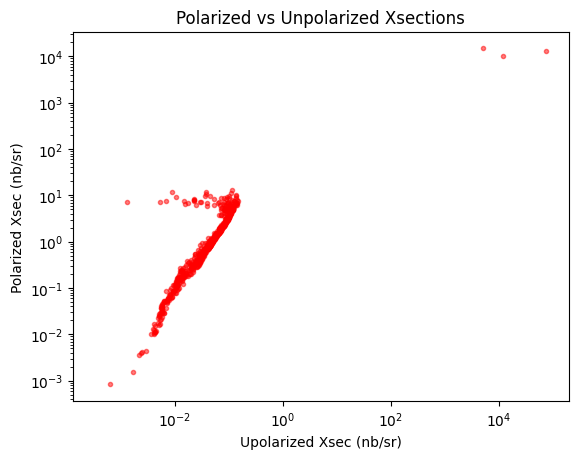

In [28]:
plt.plot(unpolarizedRightUnits,polarizedRightUnits,'.',color='red',alpha=.5)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Polarized Xsec (nb/sr)')
plt.xlabel('Upolarized Xsec (nb/sr)')
plt.title("Polarized vs Unpolarized Xsections")
#plt.ylim(1e-6,1)

Text(0.5, 0, 'Ratio')

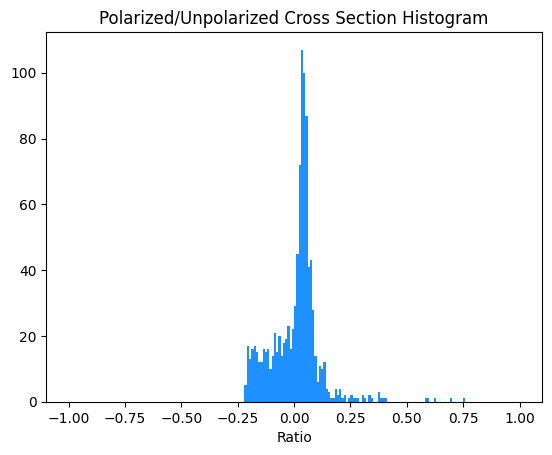

In [29]:
d=plt.hist(calcINArrayPol/calcINArray,bins=200,range=(-1,1),color='dodgerblue')
plt.title("Polarized/Unpolarized Cross Section Histogram")
plt.xlabel("Ratio")


In [30]:
#calcQEArray

In [31]:
#calcINArray

In [32]:
#plt.bar(centersS, contentsS, width=(centersS[1] - centersS[0]), align='center', alpha=0.5, color="dodgerblue", label="Simulated")
#plt.title("Dx weighted with calculated Cross Section")
#plt.bar(centersC, contentsC, width=(centersC[1] - centersC[0]), align='center', alpha=0.5, color="red", label="Calculated")
#plt.title("Dx weighted with calculated and simulated Cross Section")
#plt.legend(loc='upper right')



Text(0.5, 0, 'Unpolarized Cross Section')

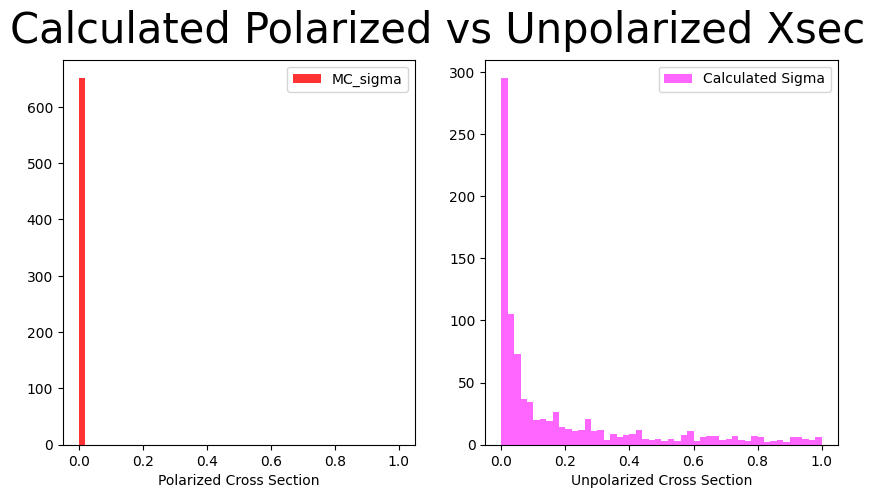

In [33]:

binsize=50
plt.figure(figsize=(10,5))
plt.suptitle('Calculated Polarized vs Unpolarized Xsec', fontsize=30)

plt.subplot(1,2,1)
#plt.xlim(0,1e-30)
x=plt.hist(calcINArrayPol*100000,color='red',alpha=.8,bins=binsize,range=(0,1),label='MC_sigma')
plt.legend(loc='upper right')
plt.xlabel("Polarized Cross Section")
plt.subplot(1,2,2)

y=plt.hist(calcINArray*100000,color='magenta',alpha=.6,bins=binsize,range=(0,1),label='Calculated Sigma')
plt.legend(loc='upper right')
plt.xlabel("Unpolarized Cross Section")


In [34]:
pol=x[0]

In [35]:
unpol=y[0]

In [36]:
pol

array([651.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.])

In [37]:
unpol

array([295., 105.,  73.,  37.,  34.,  20.,  21.,  19.,  26.,  14.,  13.,
        11.,  12.,  21.,  11.,  12.,   4.,   9.,   6.,   8.,   9.,  12.,
         5.,   4.,   5.,   3.,   5.,   3.,   8.,  11.,   3.,   6.,   7.,
         7.,   4.,   5.,   7.,   4.,   3.,   7.,   6.,   2.,   3.,   4.,
         2.,   6.,   6.,   5.,   4.,   6.])

In [38]:
pol[1]/unpol[1]

0.0

In [39]:
pol[1]

0.0

In [40]:
unpol[1]

105.0

Text(0.5, 0, 'Unpolarized Cross Section')

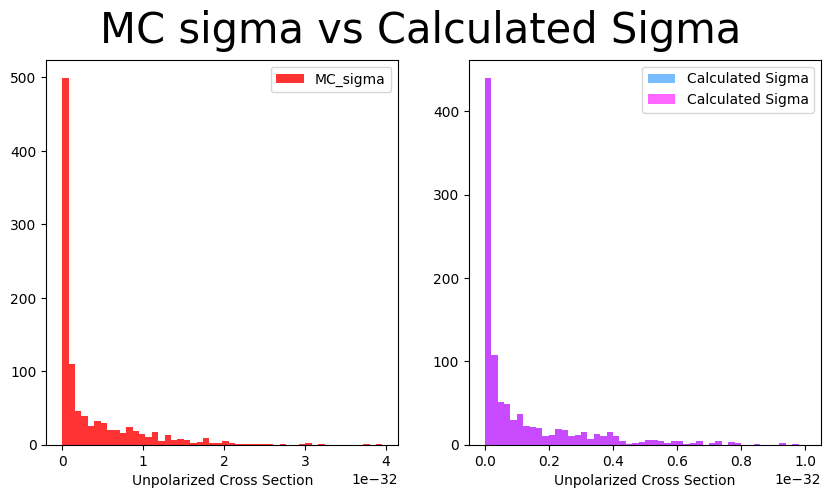

In [41]:
totalCalc=calcQEArray*hbarc+calcINArray*hbarc
binsize=50
plt.figure(figsize=(10,5))
plt.suptitle('MC sigma vs Calculated Sigma', fontsize=30)

plt.subplot(1,2,1)
x=plt.hist(simArray,color='red',alpha=.8,bins=binsize,label='MC_sigma')
plt.legend(loc='upper right')
plt.xlabel("Unpolarized Cross Section")
plt.subplot(1,2,2)
x=plt.hist(calcQEArray*hbarc+calcINArray*hbarc,color='dodgerblue',alpha=.6,bins=binsize,range=(0,1e-32),label='Calculated Sigma')
plt.legend(loc='upper right')
plt.xlabel("Unpolarized Cross Section")
x=plt.hist(calcINArray*hbarc,color='magenta',alpha=.6,bins=binsize,range=(0,1e-32),label='Calculated Sigma')
plt.legend(loc='upper right')
plt.xlabel("Unpolarized Cross Section")


/tmp/ipykernel_84265/3507125440.py:3: RuntimeWarning: divide by zero encountered in divide
  ratio = InelasticCalculated / simArray


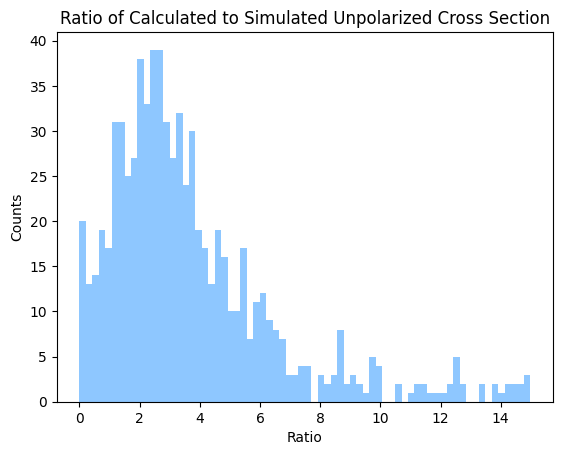

In [42]:
InelasticCalculated=electronEnergyInterval*calcINArray*hbarc

ratio = InelasticCalculated / simArray

# Create a mask to filter out -inf, inf, NaN, and 0s from both arrays
mask = np.isfinite(ratio) & (simArray != 0) & (InelasticCalculated != 0)

# Apply the mask to both arrays
filtered_totalCalc = InelasticCalculated[mask]
filtered_simArray = simArray[mask]
# Now you can safely plot the histogram of the ratio

filteredRat=filtered_totalCalc/filtered_simArray
filteredRat=filteredRat[filteredRat<15]
bin_contents=plt.hist(filteredRat,bins=70,color='dodgerblue',label="Calculated/Simulated",alpha=.5)
bin_Contents=bin_contents[0]
bin_centers=.5*(bin_contents[1][:-1]+bin_contents[1][1:])

#plt.plot(bin_centers, bin_Contents,'--',color='black',linewidth=1.5)

plt.title("Ratio of Calculated to Simulated Unpolarized Cross Section")
plt.xlabel("Ratio")
plt.ylabel("Counts")
#plt.axvline(x=3, color='black', linestyle='-', linewidth=2)
plt.show()

In [43]:
filteredRat=filtered_totalCalc/filtered_simArray
filteredRat=filteredRat[filteredRat<4]

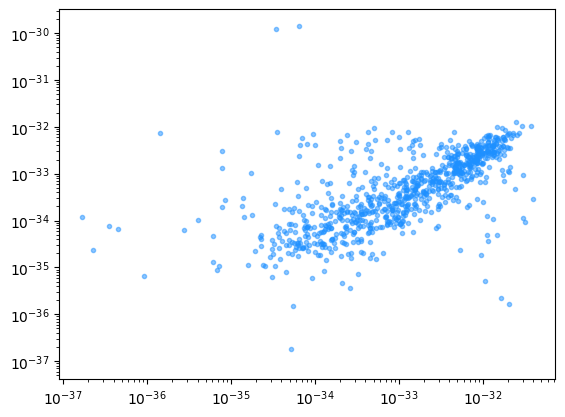

In [44]:
plt.plot(simArray,totalCalc,'.',color='dodgerblue',alpha=.5)
plt.yscale('log')
plt.xscale('log')

/tmp/ipykernel_84265/4159730312.py:3: RuntimeWarning: invalid value encountered in log10
  log_simArray = np.log10(polarizedRightUnits)
/tmp/ipykernel_84265/4159730312.py:4: RuntimeWarning: invalid value encountered in log10
  log_totalCalc = np.log10(unpolarizedRightUnits)


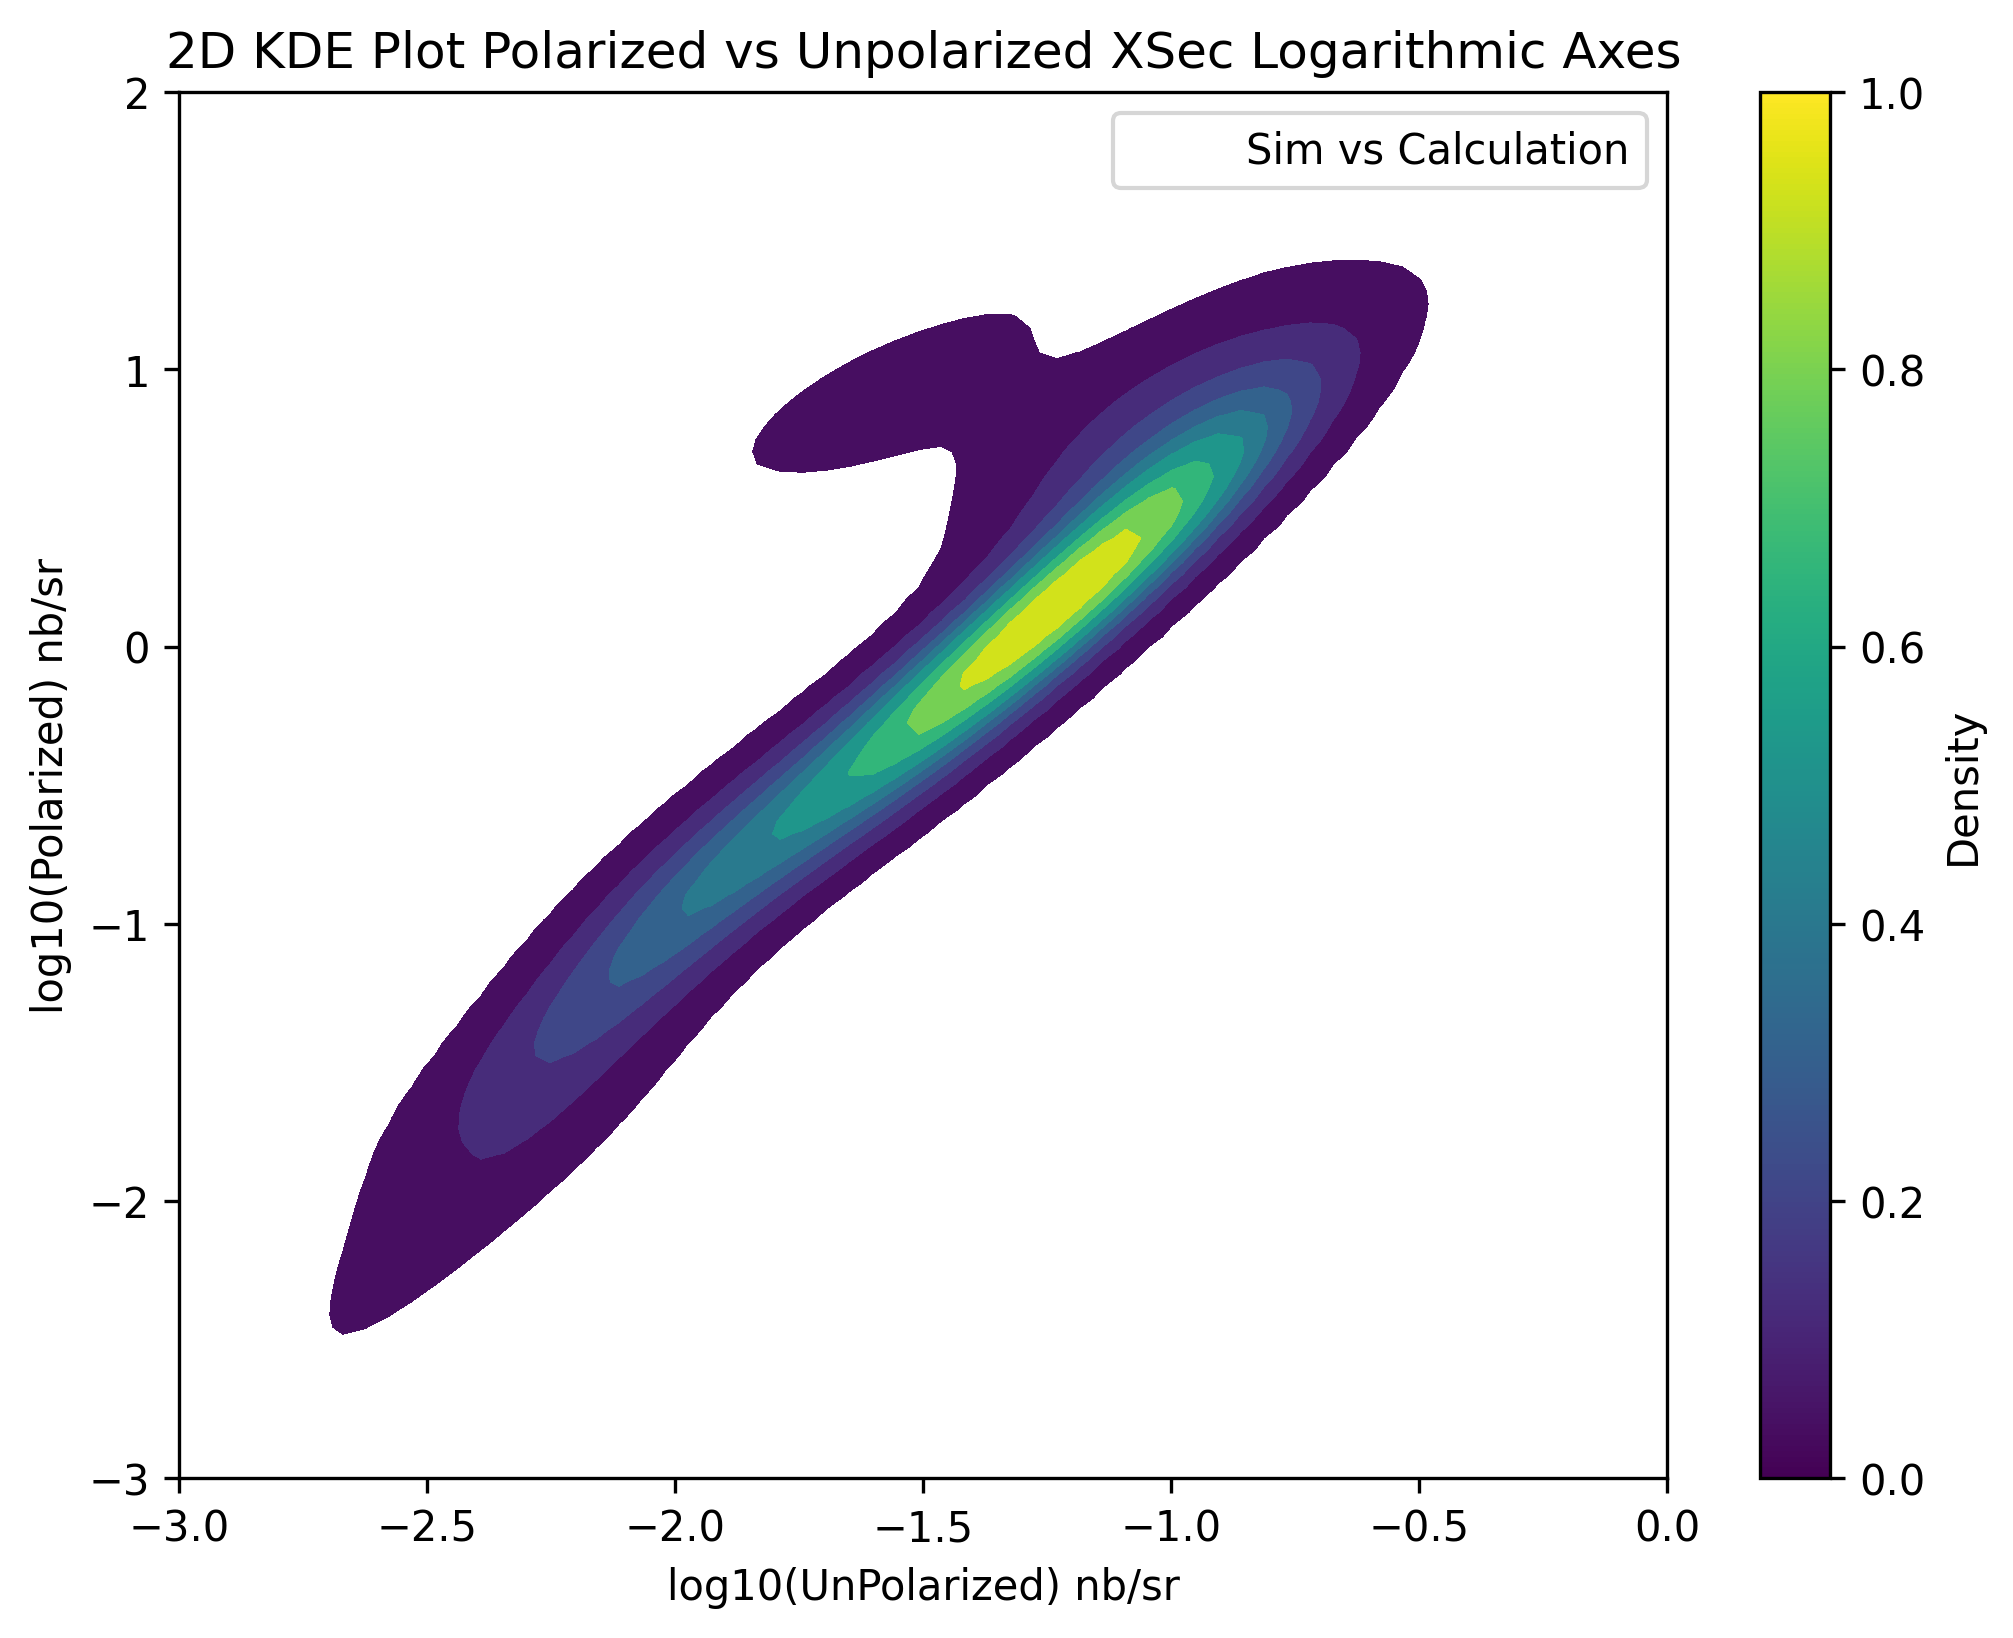

In [45]:
import seaborn as sns

log_simArray = np.log10(polarizedRightUnits)
log_totalCalc = np.log10(unpolarizedRightUnits)

plt.figure(figsize=(8, 6),dpi=300)
kde=sns.kdeplot(x=log_totalCalc, y=log_simArray, cmap='viridis', fill=True)

# Label the axes with the original scale

#
plt.xlim(-3,0)
#
plt.ylim(-3,2)
cbar = plt.colorbar(kde.collections[-1], ax=plt.gca())
cbar.set_label('Density')

# Label the axes with the original scale
plt.xlabel('log10(UnPolarized) nb/sr')
plt.ylabel('log10(Polarized) nb/sr')
plt.title('2D KDE Plot Polarized vs Unpolarized XSec Logarithmic Axes')

# Add a simple legend (though in this case, it may not be necessary)
plt.plot([], [], ' ', label='Sim vs Calculation')
plt.legend()
# Show the plot
plt.show()